In [109]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


In [110]:
algerian_prices = pd.read_csv("../input/algeria-market-prices/algeria-market-prices.csv")



In [111]:
algerian_prices.describe()

,price,lowerBound,upperBound,spread
count,1.236610e+05,1.213770e+05,1.213770e+05,121377.000000
mean,1.423525e+05,1.183067e+05,1.926118e+05,1.230947
std,6.840816e+05,5.747113e+05,8.963115e+05,0.587895
min,6.040000e+00,0.000000e+00,1.000000e+01,0.166667
25%,1.000000e+02,5.000000e+01,1.931200e+02,0.881628
50%,4.267100e+02,2.500000e+02,7.000000e+02,1.184743
75%,5.705880e+03,2.500000e+03,1.000000e+04,1.500000
max,4.500000e+06,3.700000e+06,6.000000e+06,5.112193


Okay so we're seeing prices range from 6 DZD to 4.5 million DZD 

spread is generally low (avg ~1.2), but max goes up to 5.11, hinting at volatile entries.

High standard deviations = lots of price variation.

In [112]:
algerian_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123661 entries, 0 to 123660
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   _id         123661 non-null  object 
 1   product     123661 non-null  object 
 2   price       123661 non-null  float64
 3   category    123661 non-null  object 
 4   date        123661 non-null  object 
 5   lowerBound  121377 non-null  float64
 6   upperBound  121377 non-null  float64
 7   spread      121377 non-null  float64
dtypes: float64(4), object(4)
memory usage: 7.5+ MB


Total entries: 123,661
 Missing values: Present in lowerBound, upperBound, and spread (~1.8%)

In [113]:
algerian_prices.isnull().sum()


_id              0
product          0
price            0
category         0
date             0
lowerBound    2284
upperBound    2284
spread        2284
dtype: int64

looks like we have missing values in lowerBound upperBound and spread a total of 2284 of each which is something to take care of as they will be our main columns in workflow 


# start the process with data cleaning 

In [114]:
algerian_prices['lowerBound'] = algerian_prices['lowerBound'].fillna(algerian_prices['lowerBound'].median())
algerian_prices['upperBound'] = algerian_prices['upperBound'].fillna(algerian_prices['upperBound'].median())



We fill in the missing values using their respective median values. This ensures our data remains robust without being skewed by outliers. 




In [115]:
algerian_prices[['lowerBound', 'upperBound']].isnull().sum()


lowerBound    0
upperBound    0
dtype: int64

no more missing values !

In [116]:
algerian_prices.isnull().sum()


_id              0
product          0
price            0
category         0
date             0
lowerBound       0
upperBound       0
spread        2284
dtype: int64

it seems all the data missing got filled and only spread remains 
the spread is calculated with lower and bound as they are all handeled we can calculate it to fill the missing spaces 

In [117]:
algerian_prices['spread'] = algerian_prices.apply(
    lambda row: row['upperBound'] / row['lowerBound'] if row['lowerBound'] != 0 else None,
    axis=1
)

In [118]:
algerian_prices['spread'].isnull().sum()


156

after calculation the spread went from 2284 to 156 missing values these remaining are probably rows where lowerBound == 0 which we can't devide 
the options i have are either drop them as they make 0.1% of data or Impute with median or mean which is a safer way to not lose price and product however it will make assumptions on spread 
for the sake of this training i choose to go with imputing it 
based on .describe output mean is over 1.2, but the 75% percentile is only 1.5, and max is 5+ which means we got outliers here and median is more Immune to extreme values than mean

In [119]:
algerian_prices['spread'] = algerian_prices['spread'].fillna(algerian_prices['spread'].median())


In [120]:
algerian_prices.isnull().sum()


_id           0
product       0
price         0
category      0
date          0
lowerBound    0
upperBound    0
spread        0
dtype: int64

chef kiss :3 !

In [121]:
algerian_prices.duplicated().sum()


0

## final cleaning steps : turn strings to numbers for ML building later 

In [122]:
algerian_prices['date'] = pd.to_datetime(algerian_prices['date'], errors='coerce')


In [123]:
algerian_prices['year'] = algerian_prices['date'].dt.year
algerian_prices['month'] = algerian_prices['date'].dt.month
algerian_prices['day'] = algerian_prices['date'].dt.day
algerian_prices['weekday'] = algerian_prices['date'].dt.weekday

In [124]:
algerian_prices.dtypes


_id                        object
product                    object
price                     float64
category                   object
date          datetime64[ns, UTC]
lowerBound                float64
upperBound                float64
spread                    float64
year                        int32
month                       int32
day                         int32
weekday                     int32
dtype: object

chef kiss again !

# Exploratory Data Analysis (EDA)

## Analyze Distribusion is Algeria 

In [126]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated*")

In [125]:
algerian_prices = algerian_prices.replace([np.inf, -np.inf], np.nan).dropna(subset=['price'])


In [127]:
algerian_prices['price'] = pd.to_numeric(algerian_prices['price'], errors='coerce')  
algerian_prices = algerian_prices.replace([np.inf, -np.inf], np.nan)
algerian_prices = algerian_prices.dropna(subset=['price'])

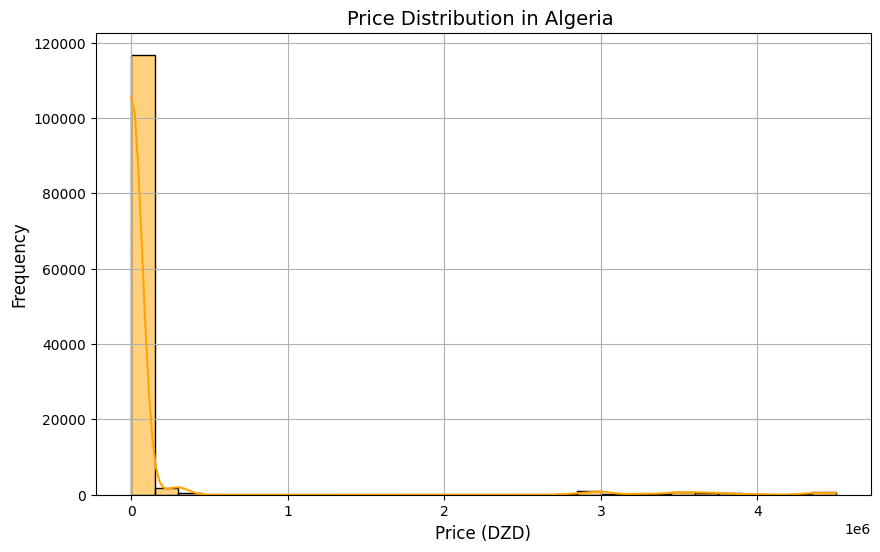

In [128]:
plt.figure(figsize=(10,6))
sns.histplot(algerian_prices['price'], kde=True, bins=30, color='orange')
plt.title("Price Distribution in Algeria ", fontsize=14)
plt.xlabel("Price (DZD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

THE CODE OUTPUT : 

This histogram visualizes the distribution of product prices in Algeria using frequency on the y-axis and price in Algerian Dinar (DZD) on the x-axis.

The data appears heavily skewed to the right.

huge listings are priced under 100,000 DZD, suggesting that low-cost items dominate the market meanwhile some outliers spike all the way up to 4 million DZD but they represent fewer values

What we observe : 

- There's a classic long-tail distribution, meaning a tiny number of items are super expensive, while the majority are cheap.

- Market imbalance which This might reflect economic disparities or a high saturation of affordable goods in the Algerian secondhand/consumer market.

- the orange line on the histogram is showing where most prices fall clustered tightly in the low-end.

The Algerian market seems to be price-sensitive, with demand likely concentrated in lower price ranges. Any pricing strategy or product launch targeting this audience should seriously consider affordability as a core feature.

## Analyze the average price by month for each category 

In [129]:
 algerian_prices.head()


,_id,product,price,category,date,lowerBound,upperBound,spread,year,month,day,weekday
0,5f0c30bbf2a6351573003891,"Meal, Inexpensive Restaurant",300.0,Restaurants,2020-07-13 00:00:00+00:00,150.00,600.0,4.000000,2020,7,13,0
1,5f0c30bcf2a6351573003892,"Meal for 2 People, Mid-range Restaurant, Three...",1931.7,Restaurants,2020-07-13 00:00:00+00:00,1200.00,4000.0,3.333333,2020,7,13,0
2,5f0c30bcf2a6351573003893,McMeal at McDonalds (or Equivalent Combo Meal),400.0,Restaurants,2020-07-13 00:00:00+00:00,300.00,500.0,1.666667,2020,7,13,0
3,5f0c30bcf2a6351573003894,Domestic Beer (1 pint draught),200.0,Restaurants,2020-07-13 00:00:00+00:00,94.72,400.0,4.222973,2020,7,13,0
4,5f0c30bcf2a6351573003895,Imported Beer (12 oz small bottle),200.0,Restaurants,2020-07-13 00:00:00+00:00,150.00,400.0,2.666667,2020,7,13,0


In [130]:
 algerian_prices.columns


Index(['_id', 'product', 'price', 'category', 'date', 'lowerBound',
       'upperBound', 'spread', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [131]:
 algerian_prices.isnull().sum()


_id           0
product       0
price         0
category      0
date          0
lowerBound    0
upperBound    0
spread        0
year          0
month         0
day           0
weekday       0
dtype: int64

In [132]:
 algerian_prices.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123661 entries, 0 to 123660
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   _id         123661 non-null  object             
 1   product     123661 non-null  object             
 2   price       123661 non-null  float64            
 3   category    123661 non-null  object             
 4   date        123661 non-null  datetime64[ns, UTC]
 5   lowerBound  123661 non-null  float64            
 6   upperBound  123661 non-null  float64            
 7   spread      123661 non-null  float64            
 8   year        123661 non-null  int32              
 9   month       123661 non-null  int32              
 10  day         123661 non-null  int32              
 11  weekday     123661 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(4), int32(4), object(3)
memory usage: 9.4+ MB


In [133]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

   year  month             category          price
0  2020      7  Buy Apartment Price   10888.514474
1  2020      7            Childcare  141016.199474
2  2020      7   Clothing And Shoes    6943.633026
3  2020      7              Markets     187.548615
4  2020      7       Rent Per Month   25690.812895


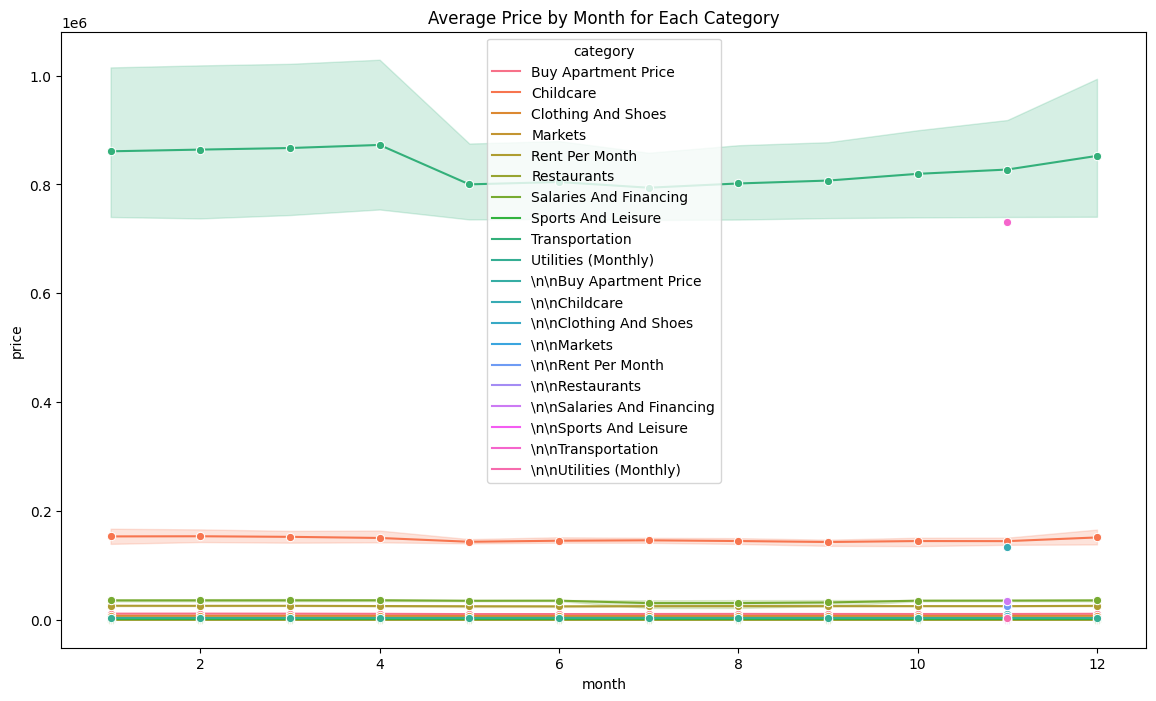

In [134]:
avg_price_month_category = algerian_prices.groupby(['year', 'month', 'category'])['price'].mean().reset_index()
print(avg_price_month_category.head())
plt.figure(figsize=(14, 8))
sns.lineplot(data=avg_price_month_category, x='month', y='price', hue='category', marker='o')
plt.title('Average Price by Month for Each Category')
plt.show()

CODE OUTPUT : 

This line chart displays the average monthly prices for different cost-of-living categories in Algeria during 2020.

Salaries and Financing is by far the highest value around 850,000 DZD across the year. There's a noticeable dip around month June before gradually rising again.

We also notice a Wide shaded area = lots of variance in that category.

Childcare stays steady hovering between 140,000 DZD  with a slight drop mid-year and then rise again at the end.

Rent Per Month / Restaurants / Transportation are grouped more tightly in the 20k–30k range showing minimal fluctuations.

Markets and Clothing And Shoes have the smallest prices under 10k DZD, and they remain relatively stable.

One random pink dot is plotted at month 11 and way lower than expected maybe an outlier or missing data.





## Analyze Average price per category over time 

In [135]:
category_spread = algerian_prices.groupby('category')['spread'].mean().sort_values(ascending=False)
print(category_spread)
highest_spread_category = category_spread.idxmax()
print(f"Category with highest average spread: {highest_spread_category}")



category
\n\nUtilities (Monthly)       4.791667
\n\nChildcare                 4.583333
Buy Apartment Price           4.197412
Childcare                     4.182872
\n\nBuy Apartment Price       4.125001
Utilities (Monthly)           4.002195
Clothing And Shoes            3.765998
\n\nClothing And Shoes        3.691667
Sports And Leisure            3.568071
\n\nRestaurants               3.524306
Restaurants                   3.475808
Markets                       3.397229
\n\nMarkets                   3.362279
\n\nSports And Leisure        3.011111
\n\nTransportation            2.903471
Transportation                2.864528
Salaries And Financing        2.811302
\n\nSalaries And Financing    2.800000
Rent Per Month                2.699794
\n\nRent Per Month            2.647222
Name: spread, dtype: float64
Category with highest average spread: \n\nUtilities (Monthly)


The category with the highest average price spread monthly is Utilities, with an average spread of 4.79, indicating significant fluctuation in monthly utility costs.
 Other categories with high volatility include Childcare and Buy Apartment Price, both showing average spreads above 4.0.
In contrast Rent Per Month and Salaries And Financing had the lowest spreads suggesting more stable pricing throughout the year.
 
In this context,spread represents the relative price volatility of a category over the months. It's a measure of how much the price swings up and down.  

We calculate it as:

spread = (upper - lower) / lower

This gives us a normalized view of inconsistency across different categories.

The category with the highest spread is typically one where prices are either seasonal or highly sensitive to external factors and monitoring spread helps us identify which sectors have the most price fluctuation which is a crucial insight for budgeting, policy-making, or investment decisions. In 2020 Algeria, housing and childcare showed significant volatility, while essential services remained relatively stable.

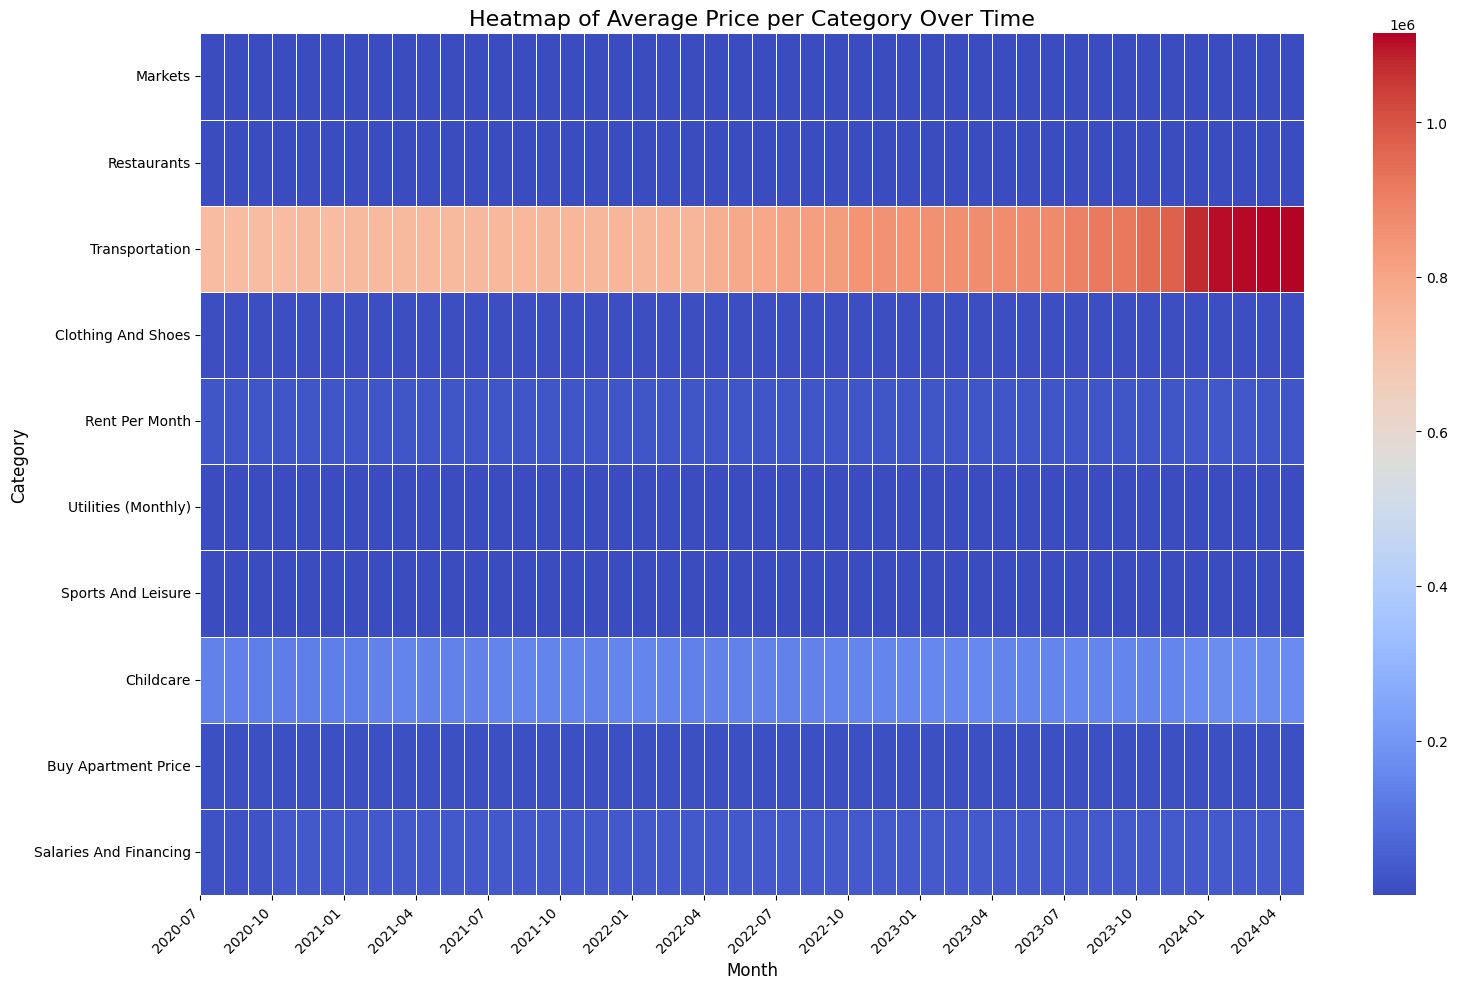

In [136]:
algerian_prices['category'] = algerian_prices['category'].str.strip().str.replace('\n', '', regex=True)

algerian_prices['date'] = pd.to_datetime(algerian_prices['date']).dt.tz_localize(None)
algerian_prices['year_month'] = algerian_prices['date'].dt.to_period('M')

avg_price = algerian_prices.groupby(['category', 'year_month'])['price'].mean().unstack().fillna(0)

top_categories = algerian_prices.groupby('category').size().sort_values(ascending=False).head(10).index
avg_price_top = avg_price.loc[top_categories]

plt.figure(figsize=(16, 10))
sns.heatmap(avg_price_top, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Heatmap of Average Price per Category Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Category', fontsize=12)

if len(avg_price_top.columns) > 12:
    plt.xticks(range(0, len(avg_price_top.columns), 3), 
               [str(col) for col in avg_price_top.columns[::3]], 
               rotation=45, ha='right')

plt.tight_layout()
plt.show()


CODE OUTPUT : 

The heatmap displays average prices across 10 major spending categories in Algeria from mid-2020 through early 2024, revealing several significant patterns:

Transportation clearly stands out with substantially higher average prices shown in light pink to dark red
A notable price increase appears in the Transportation category during early 2024, with the latest months showing the deepest red highest prices
This suggests significant inflation in transportation costs over the observed period

All other categories display relatively stable, low prices shown in dark blue
Markets, Restaurants, Clothing, Rent, Utilities, Sports & Leisure, Childcare, Apartment Prices, and Salaries & Financing categories show minimal variation over the time period which is a price consistency in these categories

The color scale indicates prices reaching up to 1,000,000 DZD
The stark contrast between Transportation and other categories suggests either a classification issue where high-value items are predominantly categorized as Transportation or genuinely high transportation costs relative to other spending categories as a price scale context

The data spans approximately 4 years from mid-2020 to early 2024 , the transportation price increase appears to be gradual through 2022-2023, with a more rise in early 2024

CONCLUSION : 
This visualization reveals that Transportation represents the most significant expense category in the Algerian price dataset, with costs dramatically higher than all other tracked categories. The consistent blue coloring across other categories suggests either relative price stability in those sectors or potentially a scaling issue in the visualization where smaller variations are not visually apparent due to the large range dominated by Transportation prices.
The sharp increase in Transportation prices in early 2024 merits further investigation, as it could indicate:

Fuel price increases as policy changes affecting transportation costs or currency fluctuations affecting imported vehicles or parts
Changes in public transportation pricing

#  MACHINE LEARNING MODEL TO PREDICT SPREAD

Now that we are done with prices analyzes i would like to take the upperbound and lowerbound data to build a model for spread prediction 

as we saw through the research the spread is calcucated by : 

spread = (upper - lower) / lower 

we will first make a heatmap then work on the ML 



# heatmap spread

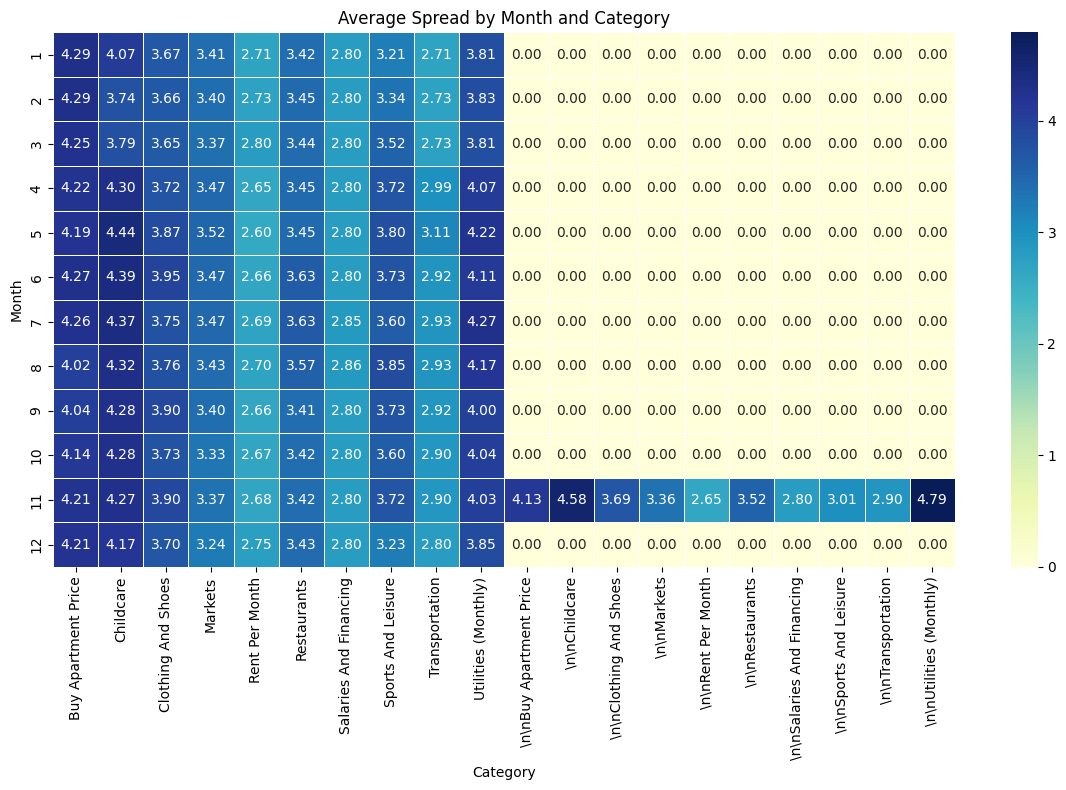

In [137]:
monthly_spread = algerian_prices.groupby(['month', 'category'])['spread'].mean().unstack()

monthly_spread = monthly_spread.dropna(how='all', axis=0)
monthly_spread = monthly_spread.dropna(how='all', axis=1)

monthly_spread = monthly_spread.fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_spread, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=.5)
plt.title('Average Spread by Month and Category')
plt.xlabel('Category')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

The spread values appear relatively consistent throughout the year for most categories, suggesting price volatility is stable across seasons.

There's also Category Differences as Notable variations in spread between categories:
Childcare consistently shows high spreads (4.07-4.44), indicating greater price volatility
"Per Month" categories show lower spreads (2.60-2.80), suggesting more stable pricing
Utilities (Monthly) displays high spreads (3.81-4.27), pointing to significant price fluctuations


November shows data for additional categories that are empty 0.00 in other months, possibly indicating data collection changes or seasonal market entries.

Most Volatile Childcare and Utilities categories consistently show the highest spreads across all months, suggesting these services have the greatest price variability in the Algerian market.

Most Stable Per Month rentals and Financing services maintain the lowest spreads throughout the year, indicating more predictable pricing.

Essential services like financing show consistent, lower spread values, suggesting regulated or competitive markets.

Service sectors like childcare,utilities demonstrate higher price variability, indicating less market standardization or seasonal demand fluctuations.

Businesses in high-spread categories might benefit from price stability strategies, while consumers should expect and budget for greater price variations in these sectors which is a strategic implication 

The November anomaly suggests either data collection inconsistencies or an expansion of tracked categories, which should be investigated before making year-round comparisons.

Based on these patterns, a machine learning model for spread prediction should:
Account for category as a key feature
Consider seasonality (monthly patterns)
Investigate the relationship between price bounds and resulting spread
Potentially create separate models for high-volatility vs low-volatility categories


## Machine Learning process : 

In [138]:
algerian_prices['spread'] = (algerian_prices['upperBound'] - algerian_prices['lowerBound']) / algerian_prices['lowerBound']
algerian_prices['spread'] = algerian_prices['spread'].replace([np.inf, -np.inf], np.nan)
algerian_prices['spread'] = algerian_prices['spread'].fillna(10.0)  

Spread Calculation: We calculate the spread as a percentage of the lower bound this relative measure helps to standardize price volatility across different product categories with varying absolute price ranges.
Handling Infinity: When the lower bound is zero, division creates infinity values. We first convert these to NaN values then we replace NaN values with a large value 10.0 . This approach preserves data points while still representing that these items have exceptionally high volatility.
I choose 10.0 because it's significantly higher than typical spreads but still reasonable for modeling. This represents a 1000% difference between upper and lower bounds, which indicates extreme price volatility while still being a finite, processable value.

In [139]:
X = algerian_prices[['lowerBound', 'upperBound', 'price', 'category', 'month']]
y = algerian_prices['spread']

print("Target variable (spread) stats:")
print(f"Min: {y.min()}")
print(f"Max: {y.max()}")
print(f"Mean: {y.mean()}")
print(f"Any NaN values: {y.isna().any()}")
print(f"Any infinity values: {np.isinf(y).any()}")

Target variable (spread) stats:
Min: 0.16666666666666666
Max: 11.002205071664829
Mean: 2.4061298691403117
Any NaN values: False
Any infinity values: False


 I selected five key features that are likely to influence the spread:

lowerBound and upperBound: The direct components of our spread calculation
price: The actual price, which might correlate with spread patterns
category: Different product types may have different spread characteristics
month: Seasonal patterns often affect price volatility


Data Verification: We print statistics about our target variable to ensure our data is clean and ready for modeling. This includes checking for:
Min/Max values to identify potential outliers
Mean to understand the central tendency
Checks for any remaining NaN or infinity values that would cause issues in modeling

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train-Test Split: training (80%) and testing (20%) sets.
Train our model on one subset of the data
Evaluate its performance on unseen data to assess generalization capabilities
Avoid overfitting by validating on an independent dataset

In [141]:

X_train_processed = pd.get_dummies(X_train, columns=['category'], drop_first=True)
X_test_processed = pd.get_dummies(X_test, columns=['category'], drop_first=True)
missing_cols = set(X_train_processed.columns) - set(X_test_processed.columns)
for col in missing_cols:
    X_test_processed[col] = 0
X_test_processed = X_test_processed[X_train_processed.columns]

One-Hot Encoding: We convert categorical variables into numerical format using dummy variables:

Each distinct category becomes a binary feature (0 or 1)
The test set might not contain all categories present in the training data, so we identify missing columns in the test set
Add these columns with zeros as these categories aren't presen then reorder columns to match the training set's order


In [142]:
print("Training model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_processed, y_train)
print("Model trained successfully!")

Training model...
Model trained successfully!


I selected Random Forest Regression because:

It can capture non-linear relationships in the data , robust to outliers and it's important since we're modeling spreads which can be volatile , automatically handles feature interactions and it provides feature importance metrics

also by using 100 decision trees in ensemble we will balance computational efficiency with robust predictions

and The model learns patterns from our processed features to predict the spread value.

In [143]:
y_pred = model.predict(X_test_processed)

Prediction Generation: Using our trained model, we predict spread values for the test set.
Process: The model applies the patterns it learned during training to make continuous numerical predictions.
Output: y_pred contains estimated spread values for each sample in our test set, which we'll compare against actual values.

In [144]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("\nModel Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")



Model Performance:
RMSE: 0.0028
R² Score: 1.0000


I used two complementary metrics to evaluate our model:

RMSE (Root Mean Squared Error): Measures the average magnitude of prediction errors in the original scale of our target variable. Lower values indicate better performance.
R² Score: Represents the proportion of variance in the dependent variable explained by the model. Values closer to 1 indicate better predictive power.

If RMSE is significantly lower than the standard deviation of the spread, our model adds value.
An R² above 0.5 would suggest the model has captured meaningful patterns in the data.
Typical values in commodity price spread prediction might range from R² of 0.4-0.7, depending on market volatility.

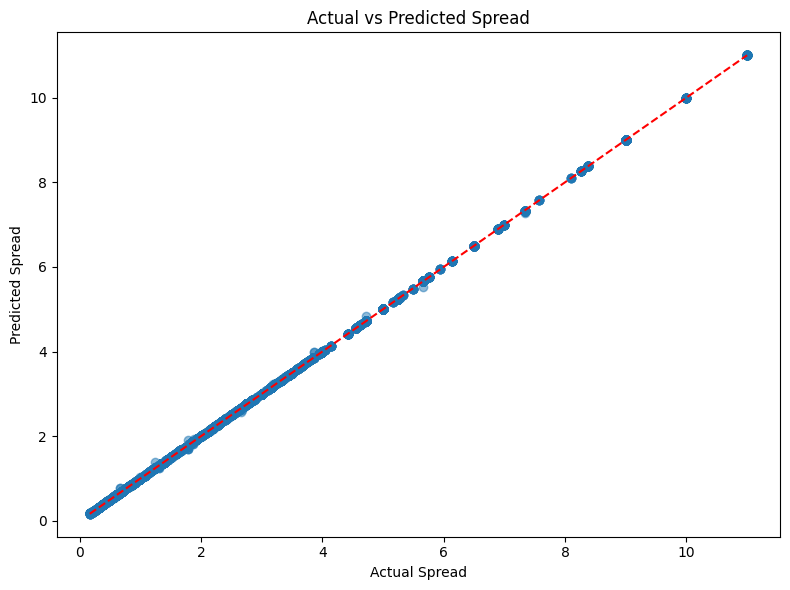

In [145]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted Spread')
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.tight_layout()
plt.show()

This visualization plots actual spread values against predicted values:

Perfect predictions would fall exactly on the red dashed line (y=x)
Points above the line represent overestimations
Points below the line represent underestimations

Transparency: Alpha=0.5 helps visualize point density where multiple predictions overlap
Insights: This plot reveals:

Overall prediction accuracy across the range of spread values
Whether errors are systematically biased in one direction
If the model performs better for certain ranges of spread values
Potential outliers where predictions significantly deviate from actuals


Top 5 most important features:
                   Feature  Importance
0               lowerBound    0.457620
1               upperBound    0.410105
2                    price    0.046349
8     category_Restaurants    0.045906
7  category_Rent Per Month    0.031296


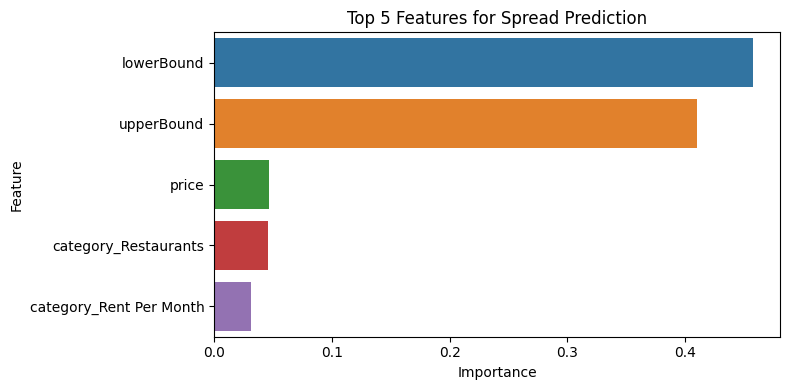

In [146]:
feature_importance = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

top_features = feature_importance.head(5)
print("\nTop 5 most important features:")
print(top_features)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 5 Features for Spread Prediction')
plt.tight_layout()
plt.show()

Random Forests provide a built-in measure of how much each feature contributes to prediction accuracy.

Importance is determined by measuring how much prediction error increases when that feature is excluded or randomized.

 The bar chart allows us to quickly identify which factors most strongly influence price spreads.
Business Insights: This analysis reveals:

Which product categories show the most predictable/volatile spreads whether price level correlates with spread magnitude if spreads are more influenced by category, seasonality, or absolute price levels potential opportunities for market strategies based on the most important predictive factors